# Imports

In [1]:
import numpy as np
import pandas as pd
import json
import os
import random
import time
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("All necessary libraries imported.")

All necessary libraries imported.


In [2]:
# --- Configuration & Seeding ---
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants for the model and data processing
WINDOW_SIZE_FRAMES = 150
STEP_SIZE_FRAMES = 30
BATCH_SIZE = 128
INPUT_FEATURES = 73  # 36 (positions) + 36 (velocities) + 1 (orientation)
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_CLASSES = 2
NUM_EPOCHS = 10 # We'll use 10 epochs for a balance of training and speed

def set_seed(seed_value: int):
    """Sets the seed for reproducibility for all relevant libraries."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Global seed set to {seed_value}")

# --- Data Handling Functions ---
def load_and_label_files(data_root: str) -> pd.DataFrame:
    """Finds all CSVs, labels them, and returns a DataFrame."""
    all_csv_files = glob(os.path.join(data_root, '**', '*.csv'), recursive=True)
    labeled_data = [{'path': file_path, 'label': 1 if 'Potential_shoplifter' in file_path else 0} for file_path in all_csv_files]
    df_files = pd.DataFrame(labeled_data)
    print(f"Found {len(df_files)} total CSV files.")
    if not df_files.empty:
        print("\nValue counts for labels:")
        print(df_files['label'].value_counts())
    return df_files

def parse_poses_from_string(poses_str: str) -> np.ndarray:
    """Helper function to parse the 'POSES' string into a numpy array."""
    try:
        return np.array(json.loads(poses_str)).reshape(18, 2)
    except (json.JSONDecodeError, ValueError):
        return np.zeros((18, 2))

def extract_features(csv_path: str) -> np.ndarray | None:
    """Reads a CSV and extracts a sequence of feature vectors."""
    df = pd.read_csv(csv_path)
    if df.empty or 'POSES' not in df.columns:
        return None

    raw_poses = np.array(df['POSES'].apply(parse_poses_from_string).tolist())
    
    # Normalized Positions
    neck_positions = raw_poses[:, 1:2, :]
    normalized_poses = raw_poses - neck_positions
    
    # Velocities
    velocities = np.diff(raw_poses, axis=0, prepend=raw_poses[0:1])
    
    # Orientation Angle
    neck_trajectory = raw_poses[:, 1, :]
    deltas = np.diff(neck_trajectory, axis=0, prepend=[neck_trajectory[0]])
    orientation_angles_deg = np.degrees(np.arctan2(deltas[:, 1], deltas[:, 0]))
    
    # Combine Features
    return np.concatenate([
        normalized_poses.reshape(raw_poses.shape[0], -1),
        velocities.reshape(raw_poses.shape[0], -1),
        orientation_angles_deg.reshape(-1, 1)
    ], axis=1)

# --- Execute ---
set_seed(SEED)
print(f"Using device: {device}")

# Define the Kaggle data root directory
data_root = '/kaggle/input/skeleton-poses-normalvsshoplifter/csvs_Skeleton_poses_normal_potential_shoplifter/'

# Load file paths and create labels
df_files = load_and_label_files(data_root)
df_files.head()

Global seed set to 42
Using device: cuda
Found 152 total CSV files.

Value counts for labels:
label
0    88
1    64
Name: count, dtype: int64


,path,label
0,/kaggle/input/skeleton-poses-normalvsshoplifte...,0
1,/kaggle/input/skeleton-poses-normalvsshoplifte...,0
2,/kaggle/input/skeleton-poses-normalvsshoplifte...,0
3,/kaggle/input/skeleton-poses-normalvsshoplifte...,0
4,/kaggle/input/skeleton-poses-normalvsshoplifte...,0


In [7]:
def get_group_id(file_path: str) -> str:
    """Extracts a unique group identifier from the file path."""
    return os.path.basename(file_path).replace('.csv', '')[-23:]

def create_sliding_windows(sequences: list, labels: list, window_size: int, step_size: int):
    """Creates overlapping windows from full sequences."""
    windowed_sequences, windowed_labels = [], []
    for i, seq in enumerate(sequences):
        if seq.shape[0] >= window_size:
            for start in range(0, seq.shape[0] - window_size + 1, step_size):
                windowed_sequences.append(seq[start:start + window_size])
                windowed_labels.append(labels[i])
    return np.array(windowed_sequences), np.array(windowed_labels)

# --- Step 1: Process all files into memory ---
print("--- Processing all CSV files into feature sequences ---")
all_sequences, all_labels, all_groups, all_paths = [], [], [], []
for _, row in tqdm(df_files.iterrows(), total=len(df_files), desc="Extracting Features"):
    features = extract_features(row['path'])
    if features is not None and len(features) > 0:
        all_sequences.append(features)
        all_labels.append(row['label'])
        all_groups.append(get_group_id(row['path']))
        all_paths.append(row['path']) # <-- ADDED: Keep track of paths

# --- Step 2: Split groups into Training and Temp (Val + Test) sets ---
print("\n--- Splitting data by group to prevent leakage ---")
gss_train_temp = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_group_indices, temp_group_indices = next(gss_train_temp.split(all_sequences, all_labels, all_groups))

train_sequences = [all_sequences[i] for i in train_group_indices]
train_labels = [all_labels[i] for i in train_group_indices]

temp_sequences = [all_sequences[i] for i in temp_group_indices]
temp_labels = [all_labels[i] for i in temp_group_indices]
temp_groups = np.array(all_groups)[temp_group_indices]
temp_paths = [all_paths[i] for i in temp_group_indices] # <-- ADDED: Track paths for temp set

# --- Step 3: Create all training, validation, and test datasets ---
print("\n--- Creating datasets: augmented for training, and both windowed & full-length for val/test ---")
X_train_windowed, y_train_windowed = create_sliding_windows(
    train_sequences, train_labels, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES
)

gss_val_test = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_indices, test_indices = next(gss_val_test.split(temp_sequences, temp_labels, temp_groups))

# Create full-length validation and test sets
X_val_long = [temp_sequences[i] for i in val_indices]
y_val_long = [temp_labels[i] for i in val_indices]
X_test_long = [temp_sequences[i] for i in test_indices]
y_test_long = [temp_labels[i] for i in test_indices]
# Keep track of the final test paths
test_paths_long = [temp_paths[i] for i in test_indices] # <-- ADDED: Final test paths

# Create the windowed versions for validation and test
X_val_windowed, y_val_windowed = create_sliding_windows(X_val_long, y_val_long, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES)
X_test_windowed, y_test_windowed = create_sliding_windows(X_test_long, y_test_long, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES)

# --- Step 4: Create PyTorch DataLoaders ---
X_train_tensor = torch.from_numpy(X_train_windowed).float()
y_train_tensor = torch.from_numpy(y_train_windowed).long()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
g = torch.Generator()
g.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

# --- Final Summary ---
print("\n--- Data Preparation Complete ---")
print(f"Total original videos processed: {len(all_sequences)}")
print(f"Training on {len(X_train_tensor)} augmented windows (from {len(train_sequences)} videos).")
print(f"Validating on {len(X_val_long)} full-length videos.")
print(f"Testing on {len(X_test_long)} full-length videos.")

--- Processing all CSV files into feature sequences ---


Extracting Features: 100%|██████████| 152/152 [00:14<00:00, 10.82it/s]



--- Splitting data by group to prevent leakage ---

--- Creating datasets: augmented for training, and both windowed & full-length for val/test ---

--- Data Preparation Complete ---
Total original videos processed: 152
Training on 20326 augmented windows (from 120 videos).
Validating on 16 full-length videos.
Testing on 16 full-length videos.


In [16]:
# --- Model Architecture ---
class RealTimeClassifier(nn.Module):
    """LSTM-based classifier with an Attention mechanism."""
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(RealTimeClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model."""
        out, _ = self.lstm(x)
        attention_scores = self.attention(out)
        attention_weights = torch.softmax(attention_scores, dim=1)
        context_vector = torch.sum(attention_weights * out, dim=1)
        context_vector_dropped = self.dropout(context_vector)
        return self.fc(context_vector_dropped)

# --- Loss Function for Imbalanced Data ---
class FocalLoss(nn.Module):
    """Focal Loss function to address class imbalance."""
    def __init__(self, alpha: torch.Tensor, gamma: float = 2.0, reduction: str = 'mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Calculates the focal loss."""
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha[targets] * (1 - pt)**self.gamma * ce_loss)
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# --- Evaluation & Reporting Helper Functions ---
def evaluate_and_report_on_test_set(
    model: nn.Module,
    test_sequences: list[np.ndarray],
    test_labels: list[int],
    device: torch.device
):
    """
    Performs the final evaluation on the test set using three methods:
    1. Per-window classification.
    2. Per-video classification (simple aggregation).
    3. Per-video classification with an optimized suspicion threshold.
    """
    model.eval()
    all_window_preds, all_window_labels = [], []
    video_suspicion_scores = []

    with torch.no_grad():
        for i, long_seq_np in enumerate(tqdm(test_sequences, desc="Evaluating Test Set")):
            y_true_video = test_labels[i]
            seq_windows_tensors = []
            
            # Create windows for the current video
            if long_seq_np.shape[0] >= WINDOW_SIZE_FRAMES:
                for start in range(0, long_seq_np.shape[0] - WINDOW_SIZE_FRAMES + 1, STEP_SIZE_FRAMES):
                    window = long_seq_np[start:start + WINDOW_SIZE_FRAMES]
                    seq_windows_tensors.append(torch.from_numpy(window))
            
            if not seq_windows_tensors:
                video_suspicion_scores.append(0.0)
                continue

            windows_batch = torch.stack(seq_windows_tensors).float().to(device)
            outputs = model(windows_batch)
            
            # For per-window report
            _, predicted_windows = torch.max(outputs, 1)
            all_window_preds.extend(predicted_windows.cpu().numpy())
            all_window_labels.extend([y_true_video] * len(predicted_windows))
            
            # For suspicion score thresholding
            probabilities = torch.softmax(outputs, dim=1)[:, 1] # Probability of 'Shoplifter' class
            avg_suspicion_score = probabilities.mean().item()
            video_suspicion_scores.append(avg_suspicion_score)

    # --- Method 1: Per-Window Report ---
    plot_report_and_matrix(all_window_labels, all_window_preds, "Test Set Evaluation (Per-Window)")
    
    # --- Method 2: Simple Per-Video Report (Flag if any window is positive) ---
    # This logic is inside `evaluate_realistically`, so we call it here for consistency
    simple_accuracy = evaluate_realistically(model, test_sequences, test_labels, device, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES)
    print(f"\n--- Test Set Evaluation (Simple Per-Video) ---")
    print(f"Accuracy (if any window is 1, predict 1): {simple_accuracy:.2f}%")

    # --- Method 3: Smart Thresholding Report ---
    y_true_video_labels = test_labels
    precisions, recalls, thresholds = precision_recall_curve(y_true_video_labels, video_suspicion_scores)
    # Use np.nan_to_num to avoid division by zero warnings
    f1_scores = np.nan_to_num(2 * (precisions * recalls) / (precisions + recalls))
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    y_pred_thresholded = [1 if score >= best_threshold else 0 for score in video_suspicion_scores]
    plot_report_and_matrix(y_true_video_labels, y_pred_thresholded, f"Test Set Evaluation (Optimal Threshold: {best_threshold:.2f})")

def plot_report_and_matrix(y_true, y_pred, title):
    """Generates and prints a classification report and plots a confusion matrix."""
    print(f"\n--- {title} ---")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Potential Shoplifter'], zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Normal', 'Potential Shoplifter'], yticklabels=['Normal', 'Potential Shoplifter'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def evaluate_realistically(model, long_sequences, long_labels, device, window_size, step_size):
    """Evaluates accuracy on full videos using simple aggregation."""
    model.eval()
    y_pred_final = []
    with torch.no_grad():
        for long_seq_np in long_sequences:
            seq_windows_tensors = []
            if long_seq_np.shape[0] >= window_size:
                for start in range(0, long_seq_np.shape[0] - window_size + 1, step_size):
                    seq_windows_tensors.append(torch.from_numpy(long_seq_np[start:start + window_size]))
            
            if not seq_windows_tensors:
                final_video_prediction = 0
            else:
                outputs = model(torch.stack(seq_windows_tensors).float().to(device))
                final_video_prediction = 1 if 1 in torch.max(outputs, 1)[1] else 0
            y_pred_final.append(final_video_prediction)
    return accuracy_score(long_labels, y_pred_final) * 100

print("Model architecture, loss functions, and evaluation helpers are defined.")

Model architecture, loss functions, and evaluation helpers are defined.


In [9]:
def run_online_training_trial(
    model: nn.Module,
    train_loader: DataLoader,
    val_windowed_loader: DataLoader,
    val_long_sequences: list[np.ndarray],
    val_long_labels: list[int],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    num_epochs: int,
    model_save_path_window: str,
    model_save_path_realistic: str,
    device: torch.device
):
    """
    Executes a full training trial for the online approach.
    It validates using two methods and saves the best model for each.
    """
    best_val_acc_window = 0.0
    best_val_acc_realistic = 0.0

    # History for plotting
    history = {'train_loss': [], 'val_acc_window': [], 'val_acc_realistic': []}

    for epoch in range(num_epochs):
        start_time = time.time()
        
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} | Training")
        for sequences, labels in train_pbar:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_pbar.set_postfix(loss=f"{loss.item():.4f}")
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- Validation Phase ---
        model.eval()
        # Method 1: Per-window accuracy
        correct_window, total_window = 0, 0
        with torch.no_grad():
            for sequences, labels in val_windowed_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                total_window += labels.size(0)
                correct_window += (predicted == labels).sum().item()
        epoch_acc_val_window = 100 * correct_window / total_window
        history['val_acc_window'].append(epoch_acc_val_window)

        # Method 2: Realistic per-video accuracy
        epoch_acc_val_realistic = evaluate_realistically(
            model, val_long_sequences, val_long_labels, device, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES
        )
        history['val_acc_realistic'].append(epoch_acc_val_realistic)
        
        # --- Epoch Summary ---
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | "
              f"Window Val Acc: {epoch_acc_val_window:.2f}% | "
              f"Realistic Val Acc: {epoch_acc_val_realistic:.2f}%")
        
        # Save best model based on PER-WINDOW accuracy
        if epoch_acc_val_window > best_val_acc_window:
            best_val_acc_window = epoch_acc_val_window
            torch.save(model.state_dict(), model_save_path_window)
            print(f"---> New best WINDOW model saved (Val Acc: {best_val_acc_window:.2f}%)")
            
        # Save best model based on REALISTIC (per-video) accuracy
        if epoch_acc_val_realistic > best_val_acc_realistic:
            best_val_acc_realistic = epoch_acc_val_realistic
            torch.save(model.state_dict(), model_save_path_realistic)
            print(f"---> New best REALISTIC model saved (Val Acc: {best_val_acc_realistic:.2f}%)")
            
    print("\n--- Finished Training Trial ---")
    return history

# --- Main Script for this Cell ---
print("--- Trial 1: Training with Standard Cross-Entropy Loss ---")
set_seed(SEED)

# Instantiate a fresh model
ce_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)

# Define criterion and optimizer
ce_criterion = nn.CrossEntropyLoss()
ce_optimizer = optim.Adam(ce_model.parameters(), lr=0.001, weight_decay=1e-4)

# Define paths for the two best models we'll save
ce_model_path_window = 'best_ce_model_window.pth'
ce_model_path_realistic = 'best_ce_model_realistic.pth'

# Run the training
ce_history = run_online_training_trial(
    model=ce_model,
    train_loader=train_loader,
    val_windowed_loader=val_windowed_loader,
    val_long_sequences=X_val_long,
    val_long_labels=y_val_long,
    criterion=ce_criterion,
    optimizer=ce_optimizer,
    num_epochs=NUM_EPOCHS,
    model_save_path_window=ce_model_path_window,
    model_save_path_realistic=ce_model_path_realistic,
    device=device
)

--- Trial 1: Training with Standard Cross-Entropy Loss ---
Global seed set to 42


Epoch 1/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.31it/s, loss=0.1523]


Epoch 1/10 | Train Loss: 0.1951 | Window Val Acc: 98.54% | Realistic Val Acc: 87.50%
---> New best WINDOW model saved (Val Acc: 98.54%)
---> New best REALISTIC model saved (Val Acc: 87.50%)


Epoch 2/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.57it/s, loss=0.0709]


Epoch 2/10 | Train Loss: 0.1047 | Window Val Acc: 97.67% | Realistic Val Acc: 62.50%


Epoch 3/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.46it/s, loss=0.0832]


Epoch 3/10 | Train Loss: 0.0682 | Window Val Acc: 97.80% | Realistic Val Acc: 50.00%


Epoch 4/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.21it/s, loss=0.0510]


Epoch 4/10 | Train Loss: 0.0646 | Window Val Acc: 99.42% | Realistic Val Acc: 68.75%
---> New best WINDOW model saved (Val Acc: 99.42%)


Epoch 5/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.42it/s, loss=0.0367]


Epoch 5/10 | Train Loss: 0.0533 | Window Val Acc: 97.47% | Realistic Val Acc: 50.00%


Epoch 6/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.38it/s, loss=0.0193]


Epoch 6/10 | Train Loss: 0.0448 | Window Val Acc: 98.12% | Realistic Val Acc: 50.00%


Epoch 7/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.42it/s, loss=0.0544]


Epoch 7/10 | Train Loss: 0.0455 | Window Val Acc: 97.89% | Realistic Val Acc: 50.00%


Epoch 8/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.75it/s, loss=0.0289]


Epoch 8/10 | Train Loss: 0.0452 | Window Val Acc: 98.57% | Realistic Val Acc: 56.25%


Epoch 9/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.54it/s, loss=0.0977]


Epoch 9/10 | Train Loss: 0.0381 | Window Val Acc: 93.64% | Realistic Val Acc: 50.00%


Epoch 10/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.41it/s, loss=0.0788]


Epoch 10/10 | Train Loss: 0.0385 | Window Val Acc: 97.50% | Realistic Val Acc: 50.00%

--- Finished Training Trial ---


--- Plotting Training History for Trial 1 (Cross-Entropy) ---


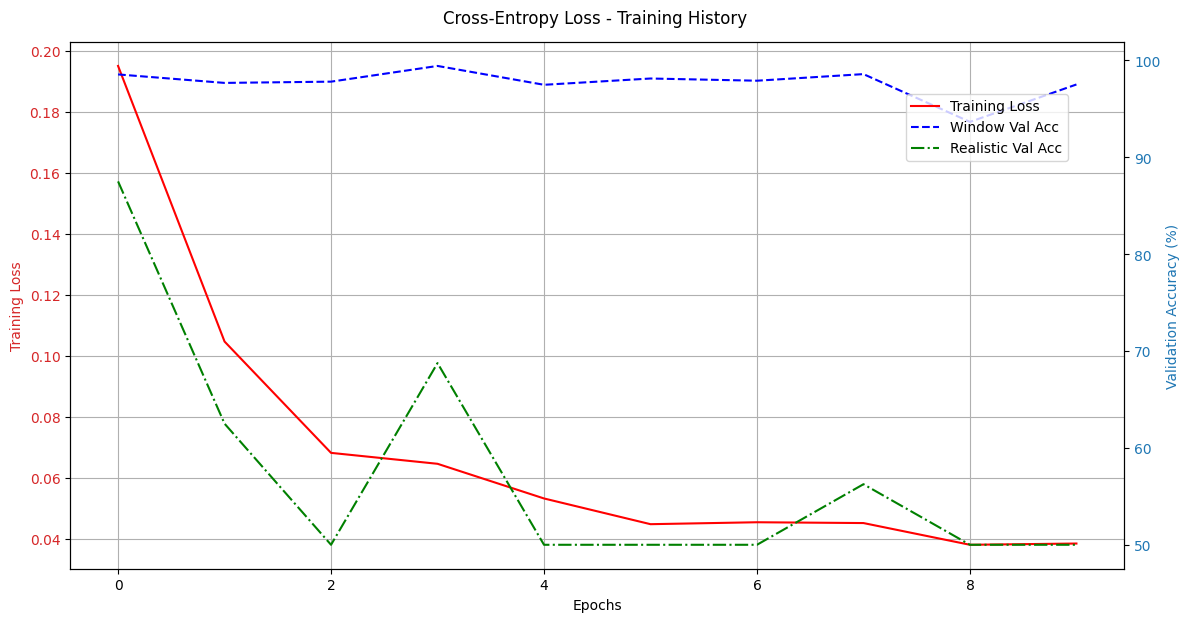


--- Loading best model for final evaluation on the Test Set ---
Global seed set to 42
Model loaded successfully from: best_ce_model_realistic.pth


Evaluating Test Set: 100%|██████████| 16/16 [00:00<00:00, 61.71it/s]



--- Test Set Evaluation (Per-Window) ---
                      precision    recall  f1-score   support

              Normal       0.96      0.93      0.95      1575
Potential Shoplifter       0.84      0.89      0.87       607

            accuracy                           0.92      2182
           macro avg       0.90      0.91      0.91      2182
        weighted avg       0.93      0.92      0.92      2182



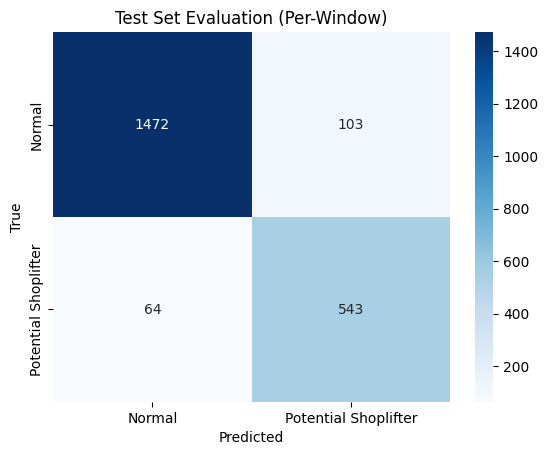


--- Test Set Evaluation (Simple Per-Video) ---
Accuracy (if any window is 1, predict 1): 50.00%

--- Test Set Evaluation (Optimal Threshold: 0.59) ---
                      precision    recall  f1-score   support

              Normal       1.00      1.00      1.00         8
Potential Shoplifter       1.00      1.00      1.00         8

            accuracy                           1.00        16
           macro avg       1.00      1.00      1.00        16
        weighted avg       1.00      1.00      1.00        16



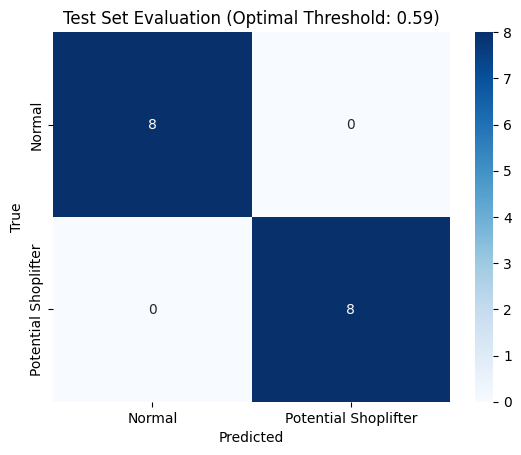

In [10]:
def plot_history(history: dict, trial_name: str):
    """Plots the training and validation history."""
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot training loss on the first y-axis
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color='tab:red')
    ax1.plot(history['train_loss'], 'r-', label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True)

    # Instantiate a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='tab:blue')
    ax2.plot(history['val_acc_window'], 'b--', label='Window Val Acc')
    ax2.plot(history['val_acc_realistic'], 'g-.', label='Realistic Val Acc')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    fig.suptitle(f'{trial_name} - Training History', y=1.03)
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

# --- Main Script for this Cell ---

# 1. Plot the training history from the Cross-Entropy trial
print("--- Plotting Training History for Trial 1 (Cross-Entropy) ---")
plot_history(ce_history, "Cross-Entropy Loss")

# 2. Load the best-performing model based on REALISTIC validation accuracy
print("\n--- Loading best model for final evaluation on the Test Set ---")
set_seed(SEED) # Reset seed for model instantiation consistency
final_ce_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
# Load the state dictionary saved from the validation loop
final_ce_model.load_state_dict(torch.load(ce_model_path_realistic))
print(f"Model loaded successfully from: {ce_model_path_realistic}")

# 3. Perform comprehensive evaluation on the TEST set
evaluate_and_report_on_test_set(
    model=final_ce_model,
    test_sequences=X_test_long,
    test_labels=y_test_long,
    device=device
)

--- Loading best model optimized for per-window performance ---
Global seed set to 42


Getting Per-Window Predictions: 100%|██████████| 18/18 [00:00<00:00, 94.74it/s]



Identified 8 videos with UroKyoro (Shoplifter) misclassifications.
Identified 8 videos with Normal Pedestrian misclassifications.


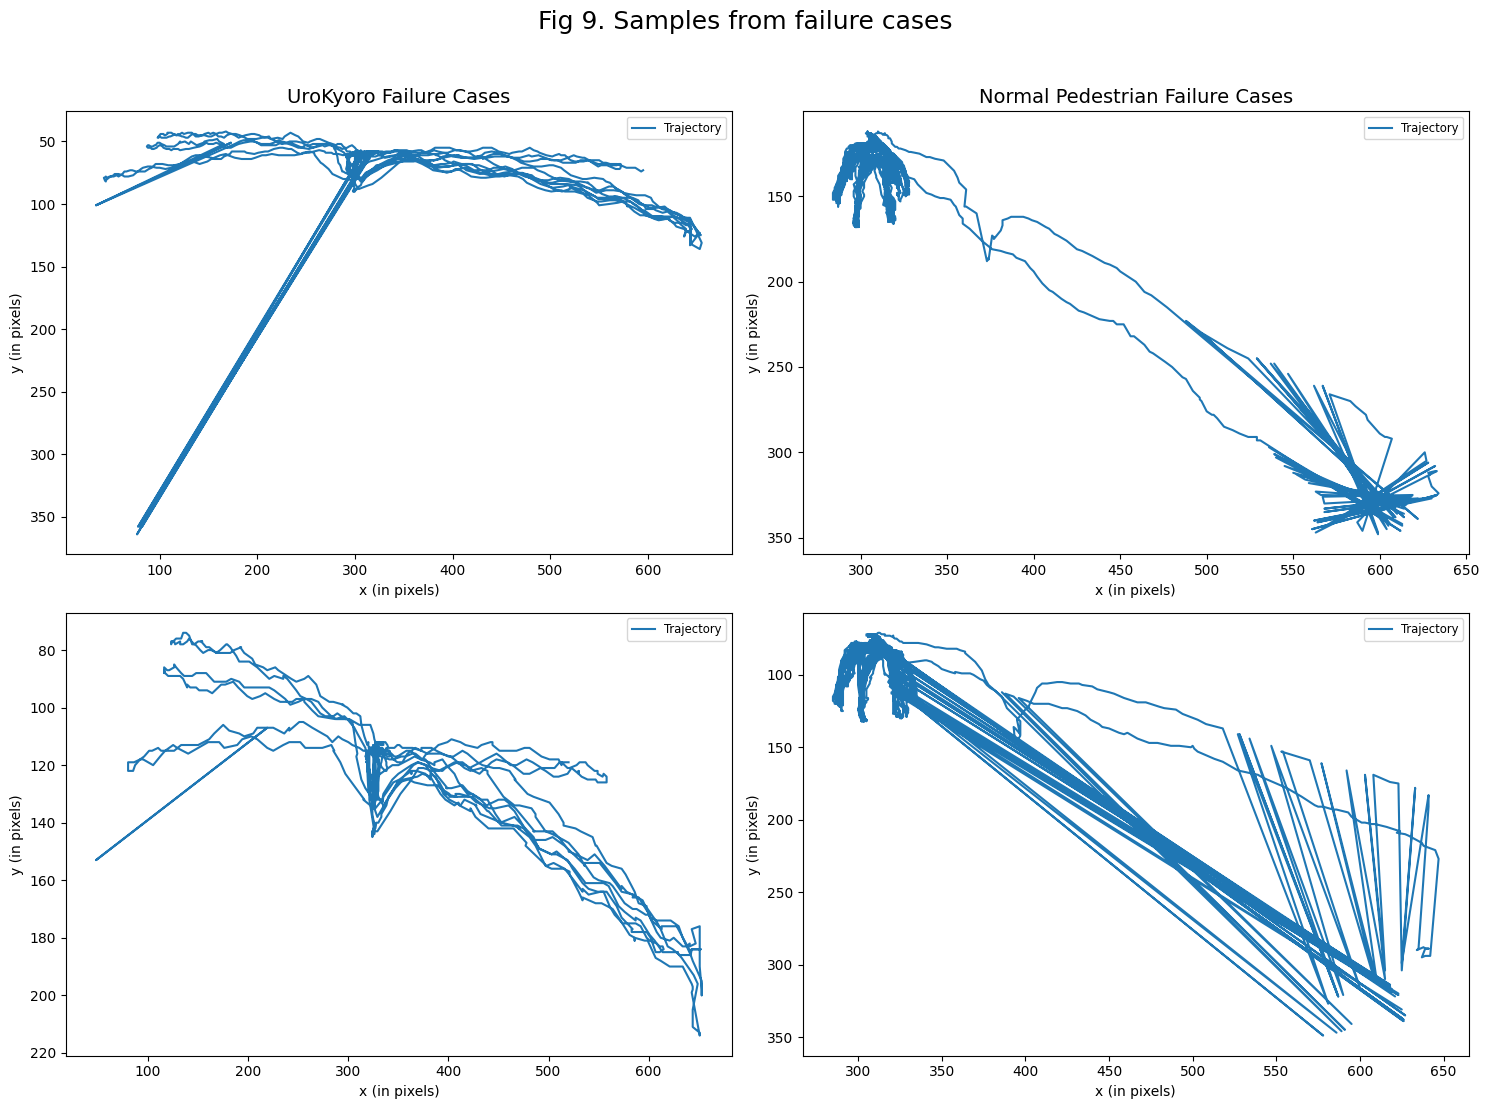

In [15]:
def plot_trajectory(csv_path: str, ax: plt.Axes):
    """
    Reads a CSV and plots the raw trajectory of the NECK keypoint on a given axis.
    This creates a single, clean line showing the person's path, similar to the paper.
    """
    df = pd.read_csv(csv_path)
    if df.empty or 'POSES' not in df.columns:
        return

    # Parse all keypoints from the CSV
    raw_poses = np.array(df['POSES'].apply(parse_poses_from_string).tolist())
    
    # --- MODIFICATION ---
    # Select ONLY the neck (keypoint at index 1) for the trajectory plot
    neck_trajectory = raw_poses[:, 1, :]
    
    # Filter out (0,0) coordinates which might be parsing errors
    neck_trajectory = neck_trajectory[np.any(neck_trajectory != 0, axis=1)]
    
    if neck_trajectory.shape[0] > 1:
        ax.plot(neck_trajectory[:, 0], neck_trajectory[:, 1], label='Trajectory')
        ax.set_xlabel('x (in pixels)')
        ax.set_ylabel('y (in pixels)')
        ax.legend(fontsize='small')
        # Invert the y-axis to match the standard image coordinate system (0,0 at top-left)
        ax.invert_yaxis()

# --- Main Script for this Cell ---

# 1. Load the model that performed best on per-window validation
print("--- Loading best model optimized for per-window performance ---")
set_seed(SEED)
window_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
window_model.load_state_dict(torch.load(ce_model_path_window)) 
window_model.eval()

# 2. Get all per-window predictions to identify videos with failures
all_window_preds = []
_, y_test_windowed_labels, test_window_source_indices = create_sliding_windows_with_indices(
    X_test_long, y_test_long, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES
)

with torch.no_grad():
    for sequences, _ in tqdm(test_windowed_loader, desc="Getting Per-Window Predictions"):
        outputs = window_model(sequences.to(device))
        all_window_preds.extend(torch.max(outputs.data, 1)[1].cpu().numpy())

# 3. Identify the source video indices that contain failures
fn_video_indices = set() # False Negatives (True Shoplifter, Predicted Normal)
fp_video_indices = set() # False Positives (True Normal, Predicted Shoplifter)

for i, (pred, true) in enumerate(zip(all_window_preds, y_test_windowed_labels)):
    if pred != true:
        source_idx = test_window_source_indices[i]
        if true == 1:
            fn_video_indices.add(source_idx)
        else:
            fp_video_indices.add(source_idx)

print(f"\nIdentified {len(fn_video_indices)} videos with Shoplifter misclassifications.")
print(f"Identified {len(fp_video_indices)} videos with Normal Pedestrian misclassifications.")

# 4. Plot trajectories, mimicking the paper's layout
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Fig 9. Samples from failure cases', fontsize=18, y=0.95)

# Left Column: UroKyoro Failure Cases (False Negatives)
fn_indices_list = list(fn_video_indices)
axes[0, 0].set_title('Shoplifter Failure Cases', fontsize=14)
for i, ax in enumerate(axes[:, 0]):
    if i < len(fn_indices_list):
        idx = fn_indices_list[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False) # Hide unused subplots

# Right Column: Normal Pedestrian Failure Cases (False Positives)
fp_indices_list = list(fp_video_indices)
axes[0, 1].set_title('Normal Pedestrian Failure Cases', fontsize=14)
for i, ax in enumerate(axes[:, 1]):
    if i < len(fp_indices_list):
        idx = fp_indices_list[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [16]:
# --- Main Script for this Cell ---
print("--- Trial 2: Training with Focal Loss ---")
set_seed(SEED)

# Instantiate a fresh model for this new trial
focal_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)

# --- Set up Focal Loss ---
# Calculate alpha weights to counter class imbalance.
# The weights are the inverse of the class frequencies.
# Original counts: 88 Normal (class 0), 64 Shoplifter (class 1)
total_videos = 88 + 64
# Weight for class 0 = (fraction of class 1)
alpha_class_0 = 64 / total_videos
# Weight for class 1 = (fraction of class 0)
alpha_class_1 = 88 / total_videos
alpha_tensor = torch.tensor([alpha_class_0, alpha_class_1]).to(device)

print(f"Calculated alpha weights for Focal Loss: {alpha_tensor.cpu().numpy()}")

# Instantiate the Focal Loss function and a new optimizer
focal_criterion = FocalLoss(alpha=alpha_tensor, gamma=2.0)
focal_optimizer = optim.Adam(focal_model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the paths for the saved models from this trial
focal_model_path_window = 'best_focal_model_window.pth'
focal_model_path_realistic = 'best_focal_model_realistic.pth'

# Run the training trial using the same helper function as before
focal_history = run_online_training_trial(
    model=focal_model,
    train_loader=train_loader,
    val_windowed_loader=val_windowed_loader,
    val_long_sequences=X_val_long,
    val_long_labels=y_val_long,
    criterion=focal_criterion,
    optimizer=focal_optimizer,
    num_epochs=NUM_EPOCHS,
    model_save_path_window=focal_model_path_window,
    model_save_path_realistic=focal_model_path_realistic,
    device=device
)

--- Trial 2: Training with Focal Loss ---
Global seed set to 42
Calculated alpha weights for Focal Loss: [0.42105263 0.57894737]


Epoch 1/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 44.34it/s, loss=0.0157]


Epoch 1/10 | Train Loss: 0.0254 | Window Val Acc: 98.51% | Realistic Val Acc: 62.50%
---> New best WINDOW model saved (Val Acc: 98.51%)
---> New best REALISTIC model saved (Val Acc: 62.50%)


Epoch 2/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.22it/s, loss=0.0078]


Epoch 2/10 | Train Loss: 0.0123 | Window Val Acc: 96.56% | Realistic Val Acc: 50.00%


Epoch 3/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 45.85it/s, loss=0.0025]


Epoch 3/10 | Train Loss: 0.0094 | Window Val Acc: 97.60% | Realistic Val Acc: 50.00%


Epoch 4/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.46it/s, loss=0.0029]


Epoch 4/10 | Train Loss: 0.0098 | Window Val Acc: 97.63% | Realistic Val Acc: 68.75%
---> New best REALISTIC model saved (Val Acc: 68.75%)


Epoch 5/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.27it/s, loss=0.0091]


Epoch 5/10 | Train Loss: 0.0080 | Window Val Acc: 97.34% | Realistic Val Acc: 50.00%


Epoch 6/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.40it/s, loss=0.0100]


Epoch 6/10 | Train Loss: 0.0077 | Window Val Acc: 98.12% | Realistic Val Acc: 50.00%


Epoch 7/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.25it/s, loss=0.0125]


Epoch 7/10 | Train Loss: 0.0075 | Window Val Acc: 97.54% | Realistic Val Acc: 50.00%


Epoch 8/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.61it/s, loss=0.0032]


Epoch 8/10 | Train Loss: 0.0072 | Window Val Acc: 97.63% | Realistic Val Acc: 50.00%


Epoch 9/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.16it/s, loss=0.0047]


Epoch 9/10 | Train Loss: 0.0058 | Window Val Acc: 97.76% | Realistic Val Acc: 50.00%


Epoch 10/10 | Training: 100%|██████████| 159/159 [00:03<00:00, 46.24it/s, loss=0.0039]


Epoch 10/10 | Train Loss: 0.0067 | Window Val Acc: 97.15% | Realistic Val Acc: 50.00%

--- Finished Training Trial ---


--- Plotting Training History for Trial 2 (Focal Loss) ---


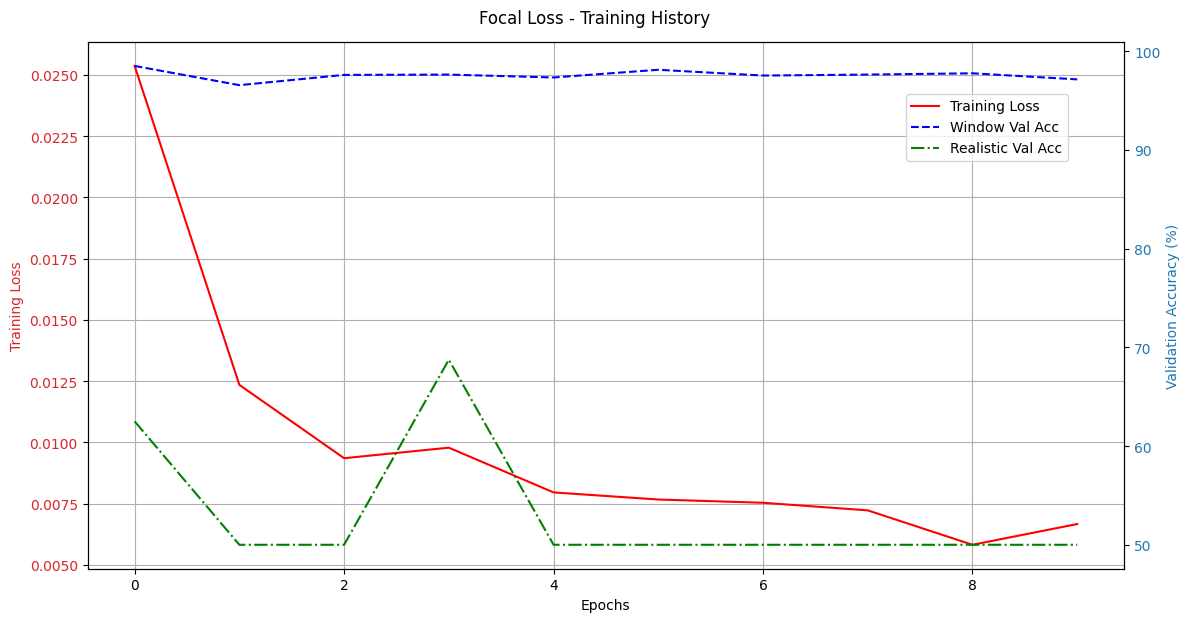


--- Loading best Focal Loss model for final evaluation on the Test Set ---
Global seed set to 42
Model loaded successfully from: best_focal_model_realistic.pth


Evaluating Test Set: 100%|██████████| 16/16 [00:00<00:00, 68.28it/s]



--- Test Set Evaluation (Per-Window) ---
                      precision    recall  f1-score   support

              Normal       0.98      0.94      0.96      1575
Potential Shoplifter       0.87      0.95      0.91       607

            accuracy                           0.95      2182
           macro avg       0.92      0.95      0.93      2182
        weighted avg       0.95      0.95      0.95      2182



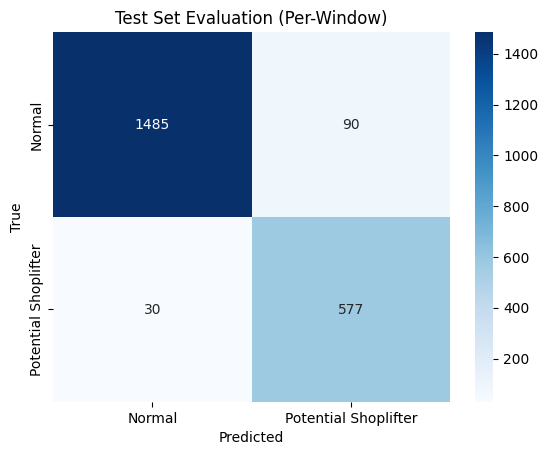


--- Test Set Evaluation (Simple Per-Video) ---
Accuracy (if any window is 1, predict 1): 50.00%

--- Test Set Evaluation (Optimal Threshold: 0.76) ---
                      precision    recall  f1-score   support

              Normal       1.00      1.00      1.00         8
Potential Shoplifter       1.00      1.00      1.00         8

            accuracy                           1.00        16
           macro avg       1.00      1.00      1.00        16
        weighted avg       1.00      1.00      1.00        16



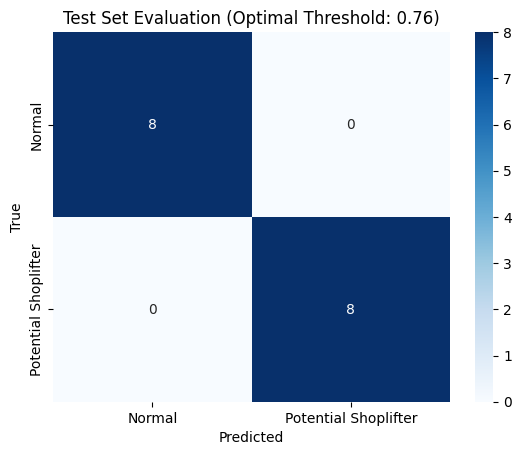


--- Visualizing Failure Cases for Trial 2 (Focal Loss) ---
Identified 0 total failure cases for the Focal Loss model.
 - 0 False Negatives (Missed Shoplifters)
 - 0 False Positives (Incorrectly Flagged Normals)


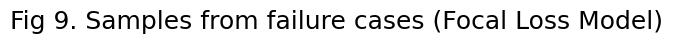

In [17]:
# --- Main Script for this Cell ---

# 1. Plot the training history from the Focal Loss trial
print("--- Plotting Training History for Trial 2 (Focal Loss) ---")
plot_history(focal_history, "Focal Loss")

# 2. Load the best-performing model based on REALISTIC validation accuracy
print("\n--- Loading best Focal Loss model for final evaluation on the Test Set ---")
set_seed(SEED) # Reset seed for model instantiation consistency
final_focal_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
final_focal_model.load_state_dict(torch.load(focal_model_path_realistic))
print(f"Model loaded successfully from: {focal_model_path_realistic}")

# 3. Perform comprehensive evaluation on the TEST set
# This will generate all three reports for the Focal Loss model
evaluate_and_report_on_test_set(
    model=final_focal_model,
    test_sequences=X_test_long,
    test_labels=y_test_long,
    device=device
)

# 4. Visualize the failure cases from the Focal Loss model
# This uses the same logic as before, but with the newly trained model
print("\n--- Visualizing Failure Cases for Trial 2 (Focal Loss) ---")

# First, get the final predictions to identify failures
focal_test_predictions = get_model_predictions_for_test_set(final_focal_model, X_test_long, y_test_long, device)
focal_failure_indices = [i for i, (pred, true) in enumerate(zip(focal_test_predictions, y_test_long)) if pred != true]

fn_failures_focal = [i for i in focal_failure_indices if y_test_long[i] == 1]
fp_failures_focal = [i for i in focal_failure_indices if y_test_long[i] == 0]

print(f"Identified {len(focal_failure_indices)} total failure cases for the Focal Loss model.")
print(f" - {len(fn_failures_focal)} False Negatives (Missed Shoplifters)")
print(f" - {len(fp_failures_focal)} False Positives (Incorrectly Flagged Normals)")


# Plot the trajectories of the failure cases
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Fig 9. Samples from failure cases (Focal Loss Model)', fontsize=18, y=0.95)

# Left Column: UroKyoro Failure Cases (False Negatives)
fn_indices_list_focal = list(fn_failures_focal)
axes[0, 0].set_title('UroKyoro Failure Cases', fontsize=14)
for i, ax in enumerate(axes[:, 0]):
    if i < len(fn_indices_list_focal):
        idx = fn_indices_list_focal[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

# Right Column: Normal Pedestrian Failure Cases (False Positives)
fp_indices_list_focal = list(fp_failures_focal)
axes[0, 1].set_title('Normal Pedestrian Failure Cases', fontsize=14)
for i, ax in enumerate(axes[:, 1]):
    if i < len(fp_indices_list_focal):
        idx = fp_indices_list_focal[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

# GCN

In [2]:
!pip install -q torch_geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

print("PyTorch Geometric and its dependencies have been installed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.9 MB/s eta 0:00:0000:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 5.6 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00:00:010:01
PyTorch Geometric and its dependencies have been installed.


In [3]:
import numpy as np
import pandas as pd
import json
import os
import random
import time
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import PyTorch Geometric libraries
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader as PyGDataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

print("--- Imports for Graph Convolutional Network (GCN) Approach ---")

# --- Configuration & Seeding ---
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model and training constants
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
# We will define other model-specific constants later

def set_seed(seed_value: int):
    """Sets the seed for reproducibility for all relevant libraries."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Global seed set to {seed_value}")

# --- Execute ---
set_seed(SEED)
print(f"Using device: {device}")
print("All necessary libraries and configurations are set up.")

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


--- Imports for Graph Convolutional Network (GCN) Approach ---
Global seed set to 42
Using device: cuda
All necessary libraries and configurations are set up.


In [4]:
# Define a fixed number of frames for each video sequence.
# Shorter sequences will be padded, longer ones will be truncated.
MAX_FRAMES = 300

# Define the skeleton's structure (the graph's edges).
# This represents the bone connections between the 18 joints.
# The indices correspond to the order of joints in the CSV files.
edge_index = torch.tensor([
    # Torso
    [1, 2], [1, 5], [2, 8], [5, 11], [8, 11], [1, 0],
    # Left Arm
    [2, 3], [3, 4],
    # Right Arm
    [5, 6], [6, 7],
    # Left Leg
    [8, 9], [9, 10],
    # Right Leg
    [11, 12], [12, 13]
], dtype=torch.long).t().contiguous()

def load_and_label_files(data_root: str) -> pd.DataFrame:
    """Finds all CSVs, labels them based on the folder, and returns a DataFrame."""
    all_csv_files = glob(os.path.join(data_root, '**', '*.csv'), recursive=True)
    labeled_data = [{'path': file_path, 'label': 1 if 'Potential_shoplifter' in file_path else 0} for file_path in all_csv_files]
    df_files = pd.DataFrame(labeled_data)
    print(f"Found {len(df_files)} total CSV files.")
    return df_files

def parse_poses_from_string(poses_str: str) -> np.ndarray:
    """Helper to parse the 'POSES' string into a numpy array."""
    try:
        return np.array(json.loads(poses_str)).reshape(18, 2)
    except (json.JSONDecodeError, ValueError):
        return np.zeros((18, 2))


class SkeletonDataset(Dataset):
    """
    Custom PyTorch Geometric Dataset for loading skeleton action recognition data.
    Each video is represented as a single graph.
    - Nodes: The 18 skeleton joints.
    - Node Features: The flattened (x, y) coordinates of each joint across all frames.
    - Edges: The predefined bone connections.
    """
    def __init__(self, df: pd.DataFrame, max_frames: int):
        super().__init__()
        self.df = df
        self.max_frames = max_frames

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        csv_path = row['path']
        label = row['label']

        # Load and parse pose data from the CSV
        df_poses = pd.read_csv(csv_path)
        raw_poses = np.array(df_poses['POSES'].apply(parse_poses_from_string).tolist()) # Shape: (n_frames, 18, 2)

        # --- Temporal Padding/Truncating ---
        n_frames = raw_poses.shape[0]
        if n_frames < self.max_frames:
            # Pad with zeros if the sequence is too short
            padding = np.zeros((self.max_frames - n_frames, 18, 2))
            processed_poses = np.concatenate([raw_poses, padding], axis=0)
        else:
            # Truncate if the sequence is too long
            processed_poses = raw_poses[:self.max_frames, :, :]

        # --- Feature Engineering ---
        # The feature for each node (joint) is its entire trajectory.
        # Reshape to (num_nodes, features_per_node) where features are (max_frames * 2)
        node_features = torch.tensor(processed_poses.transpose(1, 0, 2).reshape(18, -1), dtype=torch.float)

        # Create the graph data object
        data = Data(
            x=node_features,         # Node features: Shape [18, max_frames * 2]
            edge_index=edge_index,   # Graph connectivity
            y=torch.tensor([label], dtype=torch.long) # Label
        )
        return data

# --- Main Script for this Cell ---
data_root = '/kaggle/input/skeleton-poses-normalvsshoplifter/csvs_Skeleton_poses_normal_potential_shoplifter/'
df_files = load_and_label_files(data_root)

# Create the full dataset object
full_dataset = SkeletonDataset(df=df_files, max_frames=MAX_FRAMES)

print(f"\nSuccessfully created a dataset with {len(full_dataset)} graphs.")
print("\nExample of a single graph data object from the dataset:")
print(full_dataset[0])

Found 152 total CSV files.

Successfully created a dataset with 152 graphs.

Example of a single graph data object from the dataset:
Data(x=[18, 600], edge_index=[2, 14], y=[1])



--- Visualizing the Skeleton Graph Structure ---


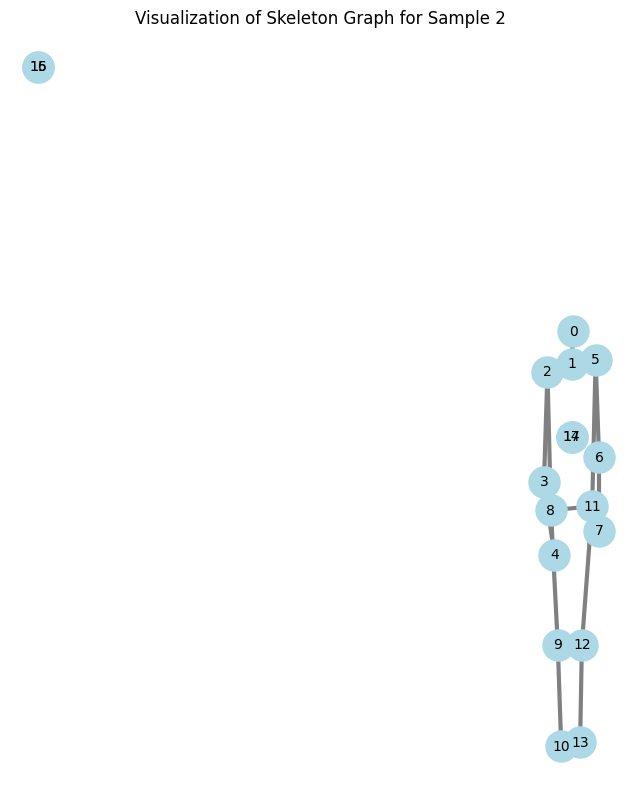

In [6]:
# Install the networkx library for graph visualization
!pip install -q networkx

import networkx as nx
from torch_geometric.utils import to_networkx

print("\n--- Visualizing the Skeleton Graph Structure ---")

# 1. Get a sample graph object from our dataset
sample_idx = 2
sample_data = full_dataset[sample_idx]

# 2. To plot a static pose, we need the (x,y) coordinates from one frame.
#    Let's read the original CSV and get the first frame's coordinates.
sample_path = df_files.iloc[sample_idx]['path']
df_sample_poses = pd.read_csv(sample_path)
first_frame_poses_str = df_sample_poses['POSES'].iloc[0]
first_frame_poses = parse_poses_from_string(first_frame_poses_str) # Shape: (18, 2)

# Create a dictionary of node positions for plotting, as required by networkx
pos = {i: (coord[0], coord[1]) for i, coord in enumerate(first_frame_poses)}

# 3. Convert our PyG Data object to a NetworkX graph object
#    We convert it to undirected because bone connections are bidirectional.
G = to_networkx(sample_data, to_undirected=True)

# 4. Plot the graph using matplotlib and networkx
plt.figure(figsize=(8, 10))
plt.title(f"Visualization of Skeleton Graph for Sample {sample_idx}")

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=500,
    font_size=10,
    width=3, # Edge width
    edge_color='grey'
)

# Invert the y-axis to match the standard image coordinate system (0,0 at top-left)
plt.gca().invert_yaxis()
plt.show()

In [9]:
from torch.utils.data import Subset

def get_group_id(file_path: str) -> str:
    """Extracts a unique group identifier from the file path."""
    return os.path.basename(file_path).replace('.csv', '')[-23:]

# --- Step 1: Create Group Identifiers ---
groups = [get_group_id(path) for path in df_files['path']]
labels = df_files['label'].values

# --- Step 2: Split data indices by group ---
# Create an array of indices [0, 1, 2, ..., n-1] to split
indices = np.arange(len(full_dataset))

# Split into training (80%) and a temporary set (20%)
gss_train_temp = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_indices, temp_indices = next(gss_train_temp.split(indices, labels, groups))

# Split the temporary indices into validation (10%) and testing (10%)
gss_val_test = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_indices, test_indices = next(gss_val_test.split(
    indices[temp_indices],
    labels[temp_indices],
    np.array(groups)[temp_indices]
))

# temp_indices must be used to index into the original dataset's indices
final_val_indices = temp_indices[val_indices]
final_test_indices = temp_indices[test_indices]

# --- Step 3: Create Subset Datasets using torch.utils.data.Subset ---
# This is the standard way to create subsets from a dataset in PyTorch.
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, final_val_indices)
test_dataset = Subset(full_dataset, final_test_indices)

# --- Step 4: Create PyTorch Geometric DataLoaders ---
# The PyG DataLoader works perfectly with torch.utils.data.Subset.
train_loader = PyGDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = PyGDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Final Summary ---
print("--- Data Splitting and DataLoader Creation Complete ---")
print(f"Total graphs: {len(full_dataset)}")
print(f"Training graphs: {len(train_dataset)}")
print(f"Validation graphs: {len(val_dataset)}")
print(f"Testing graphs: {len(test_dataset)}")
print(f"\nCreated PyG DataLoaders with batch size {BATCH_SIZE}.")

--- Data Splitting and DataLoader Creation Complete ---
Total graphs: 152
Training graphs: 120
Validation graphs: 16
Testing graphs: 16

Created PyG DataLoaders with batch size 16.


In [11]:
from torch_geometric.nn import GCNConv, global_mean_pool

class SkeletonGCN(nn.Module):
    """
    A Graph Convolutional Network for skeleton-based action recognition.
    """
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        """
        Args:
            in_channels (int): The number of features for each node. For us, this is
                               MAX_FRAMES * 2 (x,y coordinates for each frame).
            hidden_channels (int): The number of channels in the hidden GCN layers.
            out_channels (int): The number of output classes (2 for our problem).
        """
        super().__init__()
        # Ensure the seed is set for reproducible weight initialization
        torch.manual_seed(SEED)

        # Graph Convolutional Layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Classifier Head (a simple MLP)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out_channels)
        )

    def forward(self, data: Data) -> torch.Tensor:
        """
        Defines the forward pass of the GCN.

        Args:
            data (Data): A PyG Data object or a Batch object, containing:
                         - x: Node features [num_nodes, in_channels]
                         - edge_index: Graph connectivity [2, num_edges]
                         - batch: Batch vector [num_nodes] (added by DataLoader)

        Returns:
            torch.Tensor: Raw logits for classification [batch_size, out_channels]
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply GCN layers with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Global Pooling: Aggregate node features into a single graph representation
        # The `batch` vector tells the pooling function which nodes belong to which graph
        x_pooled = global_mean_pool(x, batch) # Shape: [batch_size, hidden_channels]

        # Pass the graph representation through the classifier
        out = self.classifier(x_pooled)

        return out

# --- Instantiate the model and print its architecture ---
# The number of input channels is MAX_FRAMES * 2 (300 frames * 2 coordinates)
model = SkeletonGCN(
    in_channels=MAX_FRAMES * 2,
    hidden_channels=128,
    out_channels=2
).to(device)

print("--- GCN Model Architecture ---")
print(model)

--- GCN Model Architecture ---
SkeletonGCN(
  (conv1): GCNConv(600, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [12]:
def train_one_epoch_gcn(
    model: nn.Module,
    loader: PyGDataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module
) -> float:
    """
    Trains the GCN model for one epoch.

    Returns:
        The average training loss for the epoch.
    """
    model.train()
    total_loss = 0
    for data in tqdm(loader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)


def evaluate_gcn(
    model: nn.Module,
    loader: PyGDataLoader
) -> tuple[float, list, list]:
    """
    Evaluates the GCN model on a given dataset.

    Returns:
        A tuple containing:
        - The accuracy score.
        - A list of all predictions.
        - A list of all true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating"):
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    return accuracy, all_preds, all_labels

# --- Main Script for this Cell ---
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Training and evaluation functions are defined.")
print("Criterion: CrossEntropyLoss")
print("Optimizer: Adam")

Training and evaluation functions are defined.
Criterion: CrossEntropyLoss
Optimizer: Adam


In [13]:
best_val_accuracy = 0.0
model_save_path = 'best_gcn_model.pth'
history = {'train_loss': [], 'val_acc': []}

print("--- Starting GCN Model Training ---")

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    
    # Train for one epoch
    train_loss = train_one_epoch_gcn(model, train_loader, optimizer, criterion)
    
    # Evaluate on the validation set
    val_accuracy, _, _ = evaluate_gcn(model, val_loader)
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    # Store history for plotting
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_accuracy)
    
    print(f"Epoch: {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Acc: {val_accuracy:.2f}% | "
          f"Duration: {epoch_duration:.2f}s")

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"==> New best model saved with Val Acc: {best_val_accuracy:.2f}%")

print("\n--- Finished Training ---")
print(f"The best model was saved to '{model_save_path}' with a validation accuracy of {best_val_accuracy:.2f}%.")

--- Starting GCN Model Training ---


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch: 01 | Train Loss: 18.9451 | Val Acc: 50.00% | Duration: 14.54s
==> New best model saved with Val Acc: 50.00%


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch: 02 | Train Loss: 7.0683 | Val Acc: 56.25% | Duration: 10.19s
==> New best model saved with Val Acc: 56.25%


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch: 03 | Train Loss: 4.4676 | Val Acc: 50.00% | Duration: 10.14s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch: 04 | Train Loss: 2.8668 | Val Acc: 50.00% | Duration: 10.13s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch: 05 | Train Loss: 1.4394 | Val Acc: 50.00% | Duration: 10.10s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch: 06 | Train Loss: 0.7280 | Val Acc: 68.75% | Duration: 10.05s
==> New best model saved with Val Acc: 68.75%


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch: 07 | Train Loss: 0.6724 | Val Acc: 87.50% | Duration: 10.30s
==> New best model saved with Val Acc: 87.50%


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch: 08 | Train Loss: 0.4581 | Val Acc: 50.00% | Duration: 10.57s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch: 09 | Train Loss: 0.5531 | Val Acc: 56.25% | Duration: 10.34s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch: 10 | Train Loss: 0.3337 | Val Acc: 68.75% | Duration: 10.35s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch: 11 | Train Loss: 0.5392 | Val Acc: 62.50% | Duration: 10.26s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch: 12 | Train Loss: 0.8868 | Val Acc: 50.00% | Duration: 10.11s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch: 13 | Train Loss: 0.7957 | Val Acc: 50.00% | Duration: 10.48s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch: 14 | Train Loss: 0.4184 | Val Acc: 87.50% | Duration: 10.30s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch: 15 | Train Loss: 0.1610 | Val Acc: 50.00% | Duration: 11.15s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch: 16 | Train Loss: 0.1224 | Val Acc: 50.00% | Duration: 10.33s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch: 17 | Train Loss: 0.2309 | Val Acc: 87.50% | Duration: 10.22s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch: 18 | Train Loss: 0.0934 | Val Acc: 81.25% | Duration: 10.03s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch: 19 | Train Loss: 0.0980 | Val Acc: 87.50% | Duration: 10.13s


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Epoch: 20 | Train Loss: 0.0373 | Val Acc: 68.75% | Duration: 10.07s

--- Finished Training ---
The best model was saved to 'best_gcn_model.pth' with a validation accuracy of 87.50%.


--- Plotting GCN Training History ---


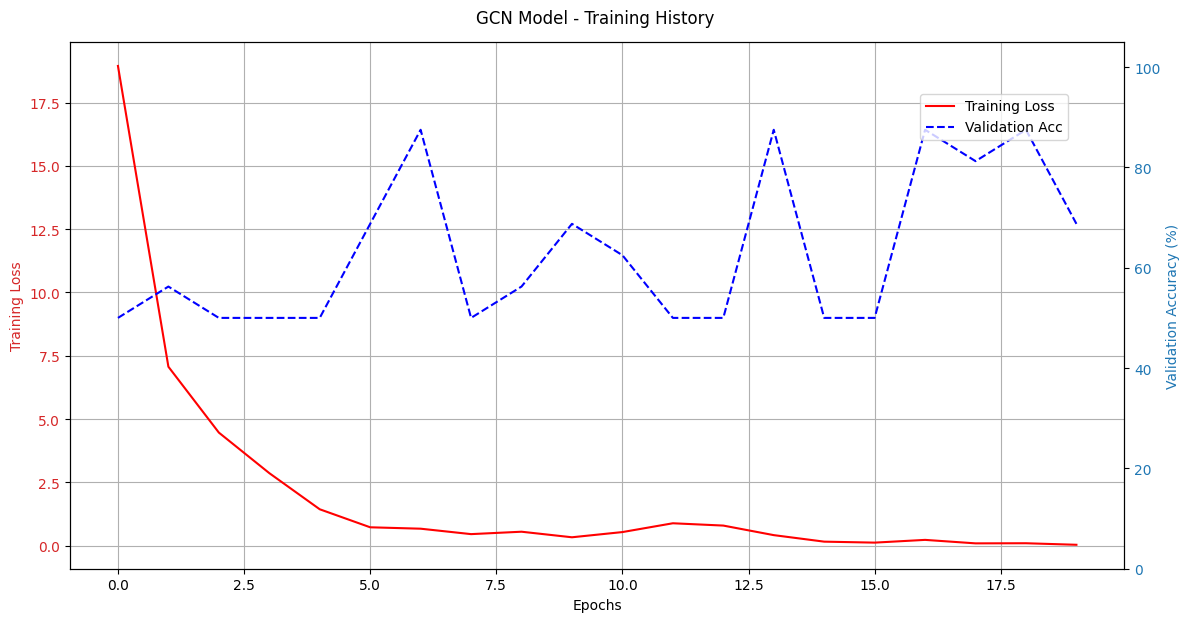


--- Loading best model for final evaluation on the Test Set ---
Model loaded successfully from: best_gcn_model.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Final Test Accuracy: 68.75%

--- GCN Final Test Set Performance ---
                      precision    recall  f1-score   support

              Normal       0.62      1.00      0.76         8
Potential Shoplifter       1.00      0.38      0.55         8

            accuracy                           0.69        16
           macro avg       0.81      0.69      0.65        16
        weighted avg       0.81      0.69      0.65        16



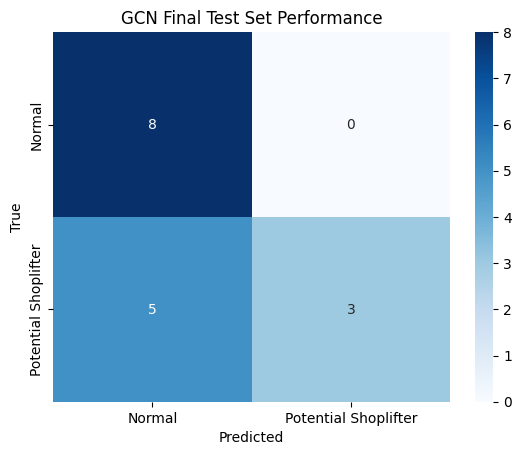

In [17]:
def plot_gcn_history(history: dict):
    """Plots the training and validation history for the GCN model."""
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot training loss on the first y-axis
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color='tab:red')
    ax1.plot(history['train_loss'], 'r-', label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True)

    # Instantiate a second y-axis for validation accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='tab:blue')
    ax2.plot(history['val_acc'], 'b--', label='Validation Acc')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(0, 105) # Set y-axis for accuracy from 0 to 105

    fig.tight_layout()
    fig.suptitle('GCN Model - Training History', y=1.03)
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

# --- Main Script for this Cell ---

# 1. Plot the training history
print("--- Plotting GCN Training History ---")
plot_gcn_history(history)


# 2. Load the best saved model for final evaluation
print("\n--- Loading best model for final evaluation on the Test Set ---")
# Instantiate a new model instance
final_model = SkeletonGCN(
    in_channels=MAX_FRAMES * 2,
    hidden_channels=128,
    out_channels=2
).to(device)

# Load the saved state dictionary
final_model.load_state_dict(torch.load(model_save_path))
print(f"Model loaded successfully from: {model_save_path}")


# 3. Evaluate on the test set
test_accuracy, test_preds, test_labels = evaluate_gcn(final_model, test_loader)
print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")


# 4. Generate and display the final report and confusion matrix
plot_report_and_matrix(
    y_true=test_labels,
    y_pred=test_preds,
    title="GCN Final Test Set Performance"
)